## light field rendering

distance of lens:

\begin{align}
\frac{1}{\mp f} = \frac{1}{\mp d} + \frac{1}{d_v} \\
d = \frac{d_v f}{d_v \pm f} \\
d_v = \frac{d f}{\pm (f-d)}
\end{align}

position of pixel on lcd:

\begin{align}
x_0 = x_n \frac{\pm d_v}{d} = \pm x_n \frac{f}{\pm(f - d)} = \pm x_n \frac{d_v \pm f}{f}
\end{align}

to avoid crosstalk $x_0>x_n  \quad \Rightarrow \quad  d_v>d$. 

adjust lens to d = 3.939 mm


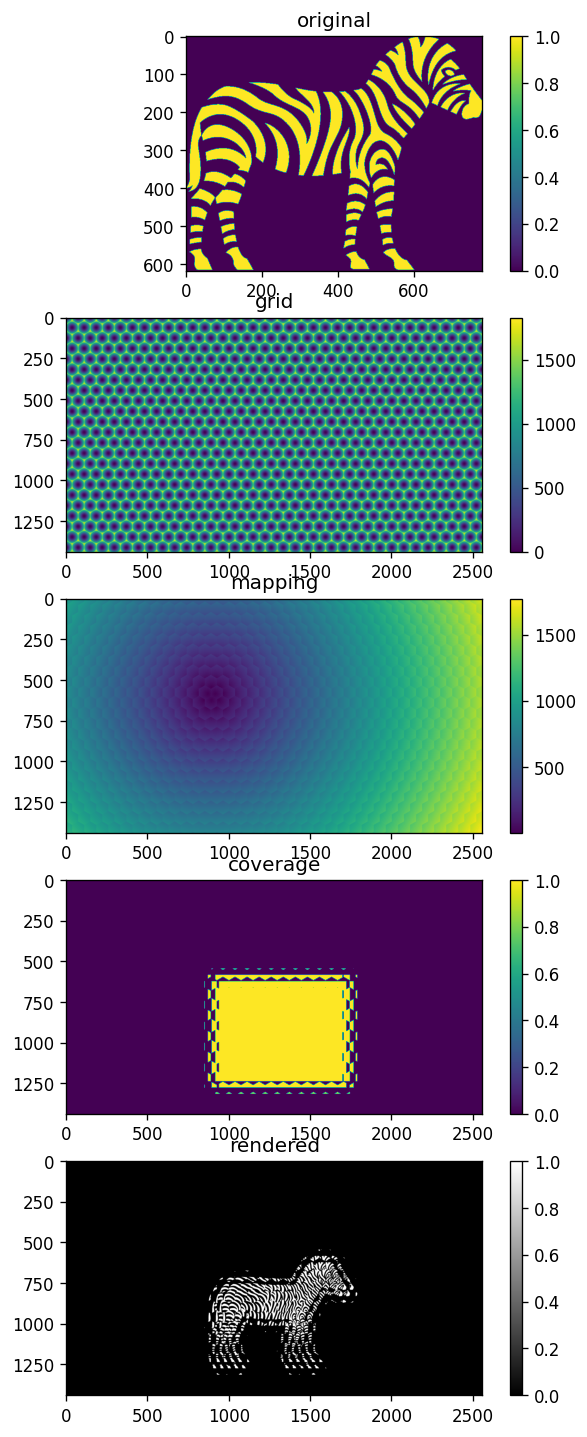

True

In [ ]:
%reset -f
import cv2
import numpy as np
import matplotlib.pyplot as plt
global pi,i
pi = np.pi; i = np.complex(0,1)

def rescale(img):
    return ( (img-img.min())*(1/(img.max()-img.min()))*255 ).astype(np.uint8)

###virtual image distance:
dv = 10 #mm
virtual_image = True

###lcd parameters (LS055R1SX03)
res = np.array([1440,2560]) #pixel
#res = np.array([1440,2880]) #pixel
dim = np.array([68.04,120.96]) #mm
#dim = 25.4/554*res #mm
pix_density = res/dim #pixel/mm

###lens parameters
#size: 66 x 63.6 x 12 (10.7)
#focal length
f = 6.5 #mm
#f = 41.9 #mm
#translation vectors of lenses

#hexagonal lens array
a = 3.5 #mm
t1 = np.array([1,0])*a #mm
t2 = np.array([np.cos(2*pi/6),np.sin(2*pi/6)])*a #mm

'''
#rectangular lens array
t1 = np.array([7,0]) #mm
t2 = np.array([0,5.4]) #mm
'''

#test alignment of t1 with x-axis
if t1[1]>0:
    raise Exception('t1[1] has to be zero for algorithm to work !')

#pixel density
p1 = pix_density*t1 #pixel/lens along vector
p2 = pix_density*t2 #pixel/lens along vector
lp1 = np.sqrt(np.sum(np.square(p1)))
lp2 = np.sqrt(np.sum(np.square(p2)))

### distance lens-lcd
if virtual_image==True:
    d = dv*f/(dv+f)
elif virtual_image==False:
    d = dv*f/(dv-f)
    dv = -dv

else:
    print('wrong setup for virtual_image: please input True or False')

print('adjust lens to d =',np.round( d ,3),'mm')
offset_scaling = dv/d

###picture
#load picture
img = cv2.imread('Zebra.png')
bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pic = bw < 150
pic = pic.astype(np.float32)
del img,bw
shape = pic.shape

#image scaling (constant virtual width wv)
wv = 20 #mm
pix_density_v = (pic.shape[1])/wv ##pixel/mm
s = 1/pix_density[1] * pix_density_v /2 #pixel/pixel

#image shift (number of LCD pixel)
x_shift = 900 #px
y_shift = 600 #px

### array rendering (fast)
# pixel array
result = np.zeros((res[0],res[1]))
#for each pixel on lcd, find lens to pass through and pixel offset
x = np.arange(res[1])
y = np.arange(res[0])
xx,yy = np.meshgrid(x,y)
p2_lens = np.round(np.divide(yy,p2[1]))
y_offset = yy - p2[1]*p2_lens
x_offset = xx - p2[0]*p2_lens
p1_lens = np.round(np.divide(x_offset,p1[0]))
x_offset = x_offset - p1[0]*p1_lens
border = (np.square(x_offset) + np.square(y_offset)) > (np.square(np.abs(x_offset)-p2[0]) + np.square(np.abs(y_offset)-p2[1]))
p2_lens = p2_lens + np.sign(p2_lens)*border
y_offset = y_offset - np.sign(y_offset)*p2[1] * border
x_offset = x_offset - np.sign(x_offset)*p2[0] * border
grid = np.square(x_offset) + np.square(y_offset)

'''
### loop rendering (slow)
# pixel array
result = np.zeros((res[0],res[1]))
for x in range(int(res[1])):
    for y in range(int(res[0])):
        #for each pixel on lcd, find lens to pass through and pixel offset
        x_offset,y_offset = x,y #pixel offset from center
        p2_lens = round(y/p2[1]) #lens_nr
        y_offset -= p2[1]*p2_lens
        x_offset -= p2[0]*p2_lens
        p1_lens = round(x_offset/p1[0]) #lens_nr
        x_offset -= p1[0]*p1_lens
        if (x_offset**2 + y_offset**2) > ((np.abs(x_offset)-p2[0])**2 + (np.abs(y_offset)-p2[1])**2):
            p2_lens += np.sign(p2_lens)
            y_offset -= np.sign(y_offset)*p2[1]
            x_offset -= np.sign(x_offset)*p2[0]
        grid[y,x] = x_offset**2 + y_offset**2
'''

#calculate virtual pixel x_0 from LCD pixel x_n (subtract offset from lens middle pixel and add offset scaled by image equation)
#afterwards scaling with s (to compensate for the pixel density difference between the given image and the LCD)
x_pix = (xx - x_shift - x_offset + x_offset*offset_scaling)*s
y_pix = (yy - y_shift - y_offset + y_offset*offset_scaling)*s
#images outside of given image are not interpolated, since they are zero
mask = np.logical_and( np.logical_and( (y_pix<(shape[0]-1)) , (y_pix>0) ) , np.logical_and( (x_pix<(shape[1]-1)) , (x_pix>0) ) )
idx = np.where(mask)
#interpolate color at virtual pixel
from scipy.interpolate import RegularGridInterpolator
interpolation = RegularGridInterpolator((np.arange(shape[1]), np.arange(shape[0])), pic.T, method='linear')#method='nearest'
result[idx] = interpolation((x_pix[idx],y_pix[idx]))

plt.figure(figsize=(6,15),dpi=120)
plt.subplot(5,1,1)
plt.title('original')
plt.imshow(pic)
plt.colorbar()
plt.subplot(5,1,2)
plt.title('grid')
plt.imshow(grid)
plt.colorbar()
plt.subplot(5,1,3)
plt.title('mapping')
plt.imshow(np.sqrt(np.square(x_pix) + np.square(y_pix)))
plt.colorbar()
plt.subplot(5,1,4)
plt.title('coverage')
plt.imshow(mask.astype(int))
plt.colorbar()
plt.subplot(5,1,5)
plt.title('rendered')
plt.imshow(result,cmap='gray')
plt.colorbar()
plt.show()
cv2.imwrite('zebra_dv_'+str(dv)+'_d_'+str(d)+'_f_'+str(f)+'.png',rescale(result))

In [ ]:
### display image in seperate window
import numpy as np
import cv2

img = cv2.imread('rendered.png')
#bw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

screen_id = 2
is_color = False

window_name = 'display'
cv2.namedWindow(window_name, cv2.WND_PROP_FULLSCREEN)
cv2.moveWindow(window_name,0,0)
cv2.setWindowProperty(window_name, cv2.WND_PROP_FULLSCREEN,
                      cv2.WINDOW_FULLSCREEN)
cv2.imshow(window_name, img)
cv2.waitKey()
cv2.destroyAllWindows()